# Idősor alapvető elemzése, megjelenítése

In [ ]:
# pandas könyvtár az adatok beolvasásához és megjelenítéséhez

import pandas as pd

In [ ]:
# google.colab könyvtár a fájlok feltöltéséhez Colab környezetben, illetve fájl kiválasztása

from google.colab import files

uploaded= files.upload()

Saving product_sales_timeseries.xlsx to product_sales_timeseries.xlsx


In [ ]:
# DataFrame létrehozása

sales_history = pd.read_excel('product_sales_timeseries.xlsx')

In [ ]:
# DataFrame első sorainak megjelenítése

sales_history.head()

,date,Product,Sales
0,201801,Product_1,134.93
1,201802,Product_1,142.95
2,201803,Product_1,167.77
3,201804,Product_1,180.99
4,201805,Product_1,129.96


## Idősor vizuális megjelenítése

In [ ]:
# pytimetk telepítése

!pip install pytimetk

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.8/233.8 kB 11.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 42.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.4/71.4 MB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.3/981.3 kB 46.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.2/102.2 kB 8.6 MB/s eta 0:00:00
  Created wheel for supersmoother: filename=supersmoother-0.4-py3-none-any.whl size=16146 sha256=1c571b26310cad22db96fa67f61337c013e1cffb1103aa00d1d8ebc6ad93d2c1
  Stored in directory: /root/.cache/pip/wheels/69/4a/ff/05c85ded597955df839bedebe6dca56297c2568c04881d2e70
Successfully built supersmoother
  Attempting uninstall: click
    Found existing installation: click 8.3.0
    Uninstalling click-8.3.0:
      Successfully uninstalled click-8.3.0


In [ ]:
# pytimetk az adatok vizuális megjelenítéséhez

import pytimetk as tk

# sales_history DataFrame date oszlopát átalakítjuk valódi dátumokká
sales_history['date'] = pd.to_datetime(sales_history['date'], format='%Y%m')

# Aggregáljuk az értékesítési adatokat dátum szerint
df_total = sales_history.groupby('date', as_index=False)['Sales'].sum()

# Kirajzoljuk az idősort
df_total.plot_timeseries(
    date_column='date',
    value_column='Sales',
    title='Total Sales',
)

/usr/local/lib/python3.12/dist-packages/cudf/utils/gpu_utils.py:75: UserWarning: Failed to dlopen libcuda.so.1


## Dekompozíció

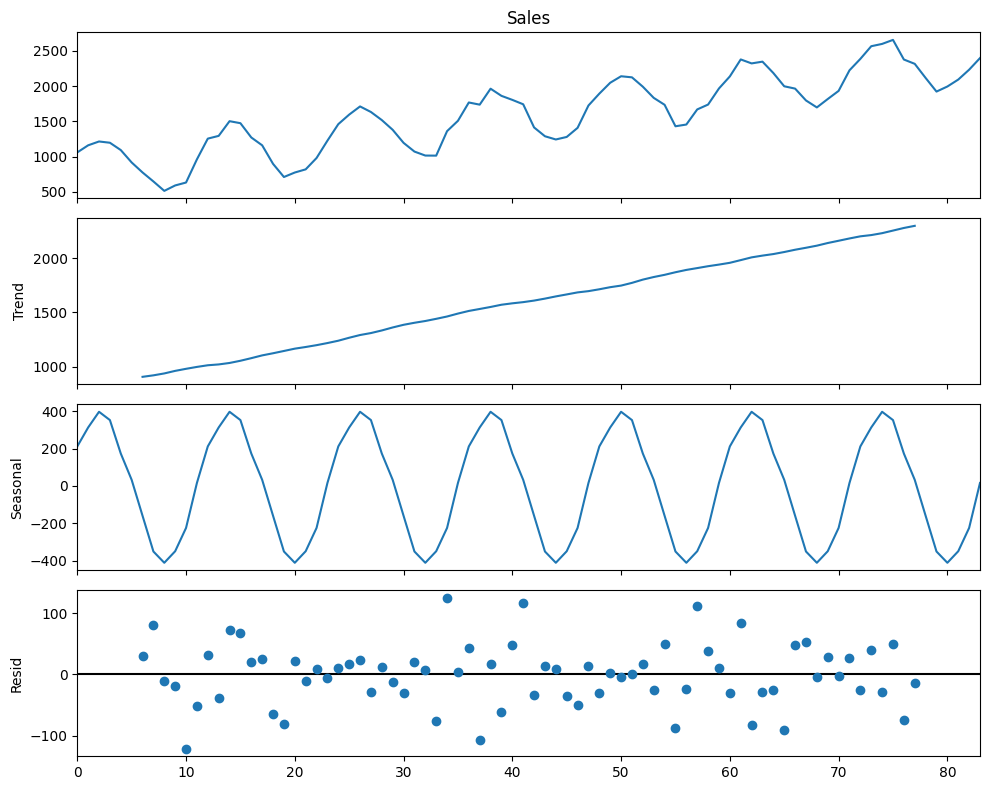

In [ ]:
# Statmodels.tsa.seasonal és matplotlib.pyplot könyvtárak importálása

from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

# Dekompozíció multiplikatív paraméterrel = az idősor komponensei szorzásos kapcsolatban állnak egymással
# period = 12 = az adatok éves szezonális ciklusban ismétlődnek

decomposition = seasonal_decompose(df_total['Sales'], model='additive', period=12)

# Vizualizáció
# A fig.set_size_inches(10,8) beállítja  a grafikon méretét
# a plt.tight_layout() gondoskodik arról, hogy a grafikon elemei ne fedjék egymást

fig = decomposition.plot()
fig.set_size_inches(10, 8)
plt.tight_layout()
plt.show()

## Autokorreláció

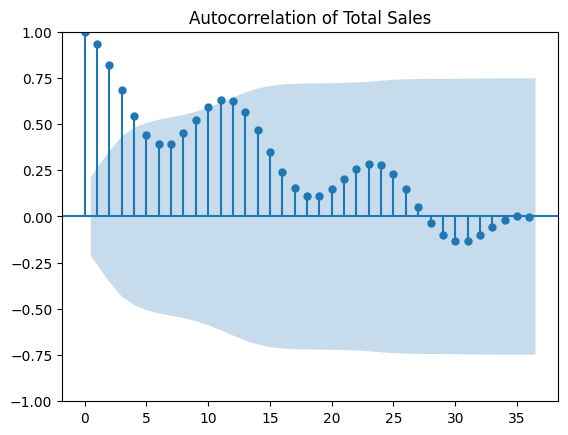

In [ ]:
# Statmodels.tsa.seasonal könyvtár plot_acf függvényének importálása
# matplotlib.pyplot könyvtár importálása

from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt

# Autokorrelációs plot
# A plot_acf() kiszámítja és ábrázolja a df_total['Sales'] idősor autokorrelációs értékeit
# lags = 36, tehát 36 időegységnyi eltolásig vizsgáljuk az autokorrelációt – ez itt 3 évnyi adatot jelent
# plt.show() az ábra megjelenítéséhez

plot_acf(
    df_total['Sales'],
    lags=36,
    title='Autocorrelation of Total Sales'
)
plt.show()

# Top-Down

## Naive előrejelzés

In [ ]:
# Konvertáljuk a 'date' oszlopot dátum formátumra és állítsuk be indexnek (így majd a vizualizáció időalapú lesz, nem csak sorszám alapú)
df_total['date'] = pd.to_datetime(df_total['date'])
df_total = df_total.set_index('date')

# Hónapok számának meghatározása a train adathalmazhoz
train_size = 72

# Első 72 sor kiválasztása train célra
train_df = df_total.iloc[:train_size]

# A maradék 12 sort tesztelésre használjuk
test_df = df_total.iloc[train_size:]

# A 80-20% train-test arány bevett gyakorlatnak számít, így a modellnek van elég adat tanulni.
# Végül egy egész évet hagytam a test szakasznak, az egyszerűség és értelmezhetőség kedvéért

# Lekérjük az train adathalmaz utolsó értékesítési adatát - ez lesz a naiv előrejelzés alapja
last_train_value = train_df['Sales'].iloc[-1]

# Létrehozunk egy új sorozatot, amely minden tesztidőpontra ugyanazt az értéket jósolja
forecast_test = pd.Series(last_train_value, index=test_df.index)

In [ ]:
# sklearn.metrics könyvtárból a mean_absolute_error és a mean_squared_error importálása

from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# MAE és RMSE értékek kiszámítása az előrejelzés és a valós adatok között

mae = mean_absolute_error(test_df['Sales'], forecast_test)
rmse = np.sqrt(mean_squared_error(test_df['Sales'], forecast_test))

# MAE és RMSE értékének kiírása

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Root Mean Squared Error (RMSE): {rmse}")

Mean Absolute Error (MAE): 208.955
Root Mean Squared Error (RMSE): 242.21681341310722


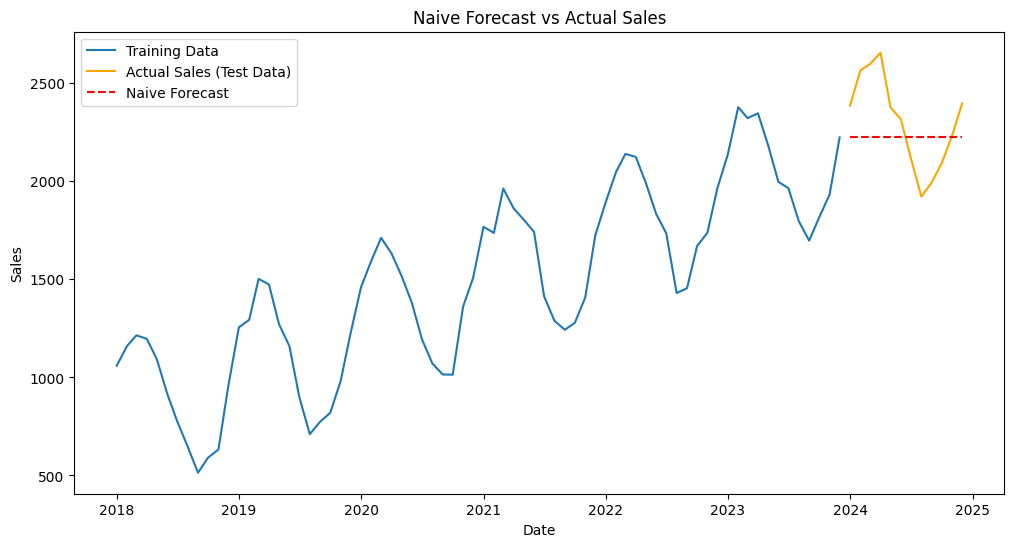

In [ ]:
# matplotlib.pyplot könyvtár a vizualizációhoz

import matplotlib.pyplot as plt

# Adatok megjelenítése

plt.figure(figsize=(12, 6)) # grafikon méretének beállítása
plt.plot(train_df.index, train_df['Sales'], label='Training Data') # tréning adatok megjelenítése
plt.plot(test_df.index, test_df['Sales'], label='Actual Sales (Test Data)', color='orange') # tényleges értékesítési adatok (teszt adatok) megjelenítése
plt.plot(forecast_test.index, forecast_test, label='Naive Forecast', color='red', linestyle='--') # naive forecast megjelenítése

# Cím, tengelyek, jelmagyarázat

plt.title('Naive Forecast vs Actual Sales')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()

 ## Exponenciális simítás

In [ ]:
# statmodels könyvtár Holt-Winters ExponentialSmoothing füvvgényének importálása

from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Modell létrehozása és illesztése

model = ExponentialSmoothing(
    train_df['Sales'],
    trend='add', # az adatok trendje additív
    seasonal='add', # az adatok szezonális komponense additív
    seasonal_periods=12 # 12 irőszakos ciklus
)
fitted_model = model.fit() # modell illesztése a tréning adatokra

In [ ]:
# Előrejelzés készítése a test időszakra
forecast = fitted_model.forecast(steps=len(test_df))

# az indexet a tesztadatok indexére állítjuk, hogy összehasonlítható legyen
forecast.index = test_df.index

In [ ]:
# Hibamutatók számítása

from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

mae_exp_smoothing = mean_absolute_error(test_df['Sales'], forecast)
rmse_exp_smoothing = np.sqrt(mean_squared_error(test_df['Sales'], forecast))

# Eredmények kiírása

print(f"Exponential Smoothing - Mean Absolute Error (MAE): {mae_exp_smoothing}")
print(f"Exponential Smoothing - Root Mean Squared Error (RMSE): {rmse_exp_smoothing}")

Exponential Smoothing - Mean Absolute Error (MAE): 48.97168245310426
Exponential Smoothing - Root Mean Squared Error (RMSE): 53.08614354584681


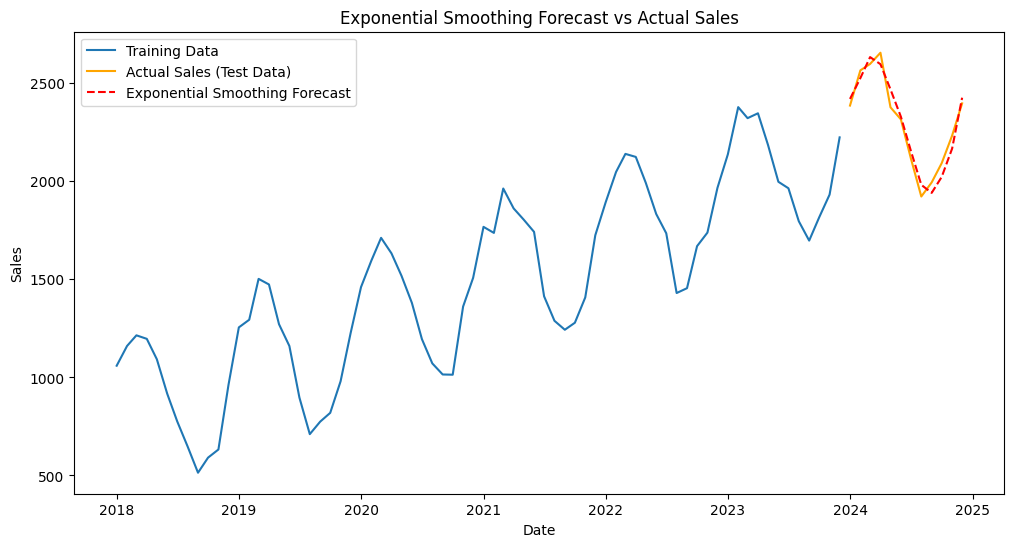

In [ ]:
# Vizualizáció

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(train_df.index, train_df['Sales'], label='Training Data')
plt.plot(test_df.index, test_df['Sales'], label='Actual Sales (Test Data)', color='orange')
plt.plot(forecast.index, forecast, label='Exponential Smoothing Forecast', color='red', linestyle='--')
plt.title('Exponential Smoothing Forecast vs Actual Sales')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()

## SARIMA

In [ ]:
# ARIMA modell importálása a statmodels könyvtárból, valamint metrikák és numerikus eszközök importálása

from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import matplotlib.pyplot as plt


# PARAMÉTER OPTIMALIZÁLÁS (GRID SEARCH)

# Train adatok kiválasztása az idősorból
train_data_arima = train_df['Sales']

# ARIMA modell három paraméterének (p, d, q) lehetséges értékeinek beállítása
# Ezek a tartományok elég szélesek ahhoz, hogy lefedjék a legtöbb gyakori ARIMA konfigurációt
# De nem túl nagyon, így a grid search futási ideje még ésszerű marad (összesen 6x3x6 = 108 kombináció)

p_values = range(0, 6)
d_values = range(0, 3)
q_values = range(0, 6)

# A legjobb modell kereséséhez szükséges változók kezdeti értékeinek beállytása (inicializálás)

best_aic = float("inf")
best_order = None
best_model = None

# Végigpróbáljuk az összes (p, d, q) kombinációt, és kiválasztjuk azt, amelyiknek a legkisebb az AIC értéke
# Tehát amelyiknél a legmagasabb a modell illeszkedésének minősége

for p in p_values:
    for d in d_values:
        for q in q_values:
            try:
                model = ARIMA(train_data_arima, order=(p, d, q))
                fitted = model.fit()
                if fitted.aic < best_aic:
                    best_aic = fitted.aic
                    best_order = (p, d, q)
                    best_model = fitted
            except Exception:
                continue


# Kiírjuk, hogy melyek a legjobb ARIMA paraméterek

print(f"Legjobb ARIMA paraméterek: {best_order}, AIC: {best_aic:.2f}")

# Elmentjük a legjobb modellt a további lépésekhez
fitted_arima = best_model

Legjobb ARIMA paraméterek: (5, 2, 4), AIC: 817.56


In [ ]:
# Előrejelzés készítése a test adatok időszakára
start_index = len(train_data_arima)
end_index = len(df_total) - 1
predictions_arima = fitted_arima.predict(start=start_index, end=end_index)

# Előrejelzés indexének hozzárendelése a test adatokhoz
# Az összehasonlíthatóság, egymás mellé rendezhetőség érdekében
predictions_arima.index = test_df.index


# ARIMA modell értékelése
mae_arima = mean_absolute_error(test_df['Sales'], predictions_arima)
rmse_arima = np.sqrt(mean_squared_error(test_df['Sales'], predictions_arima))

print(f"ARIMA - Mean Absolute Error (MAE): {mae_arima}")
print(f"ARIMA - Root Mean Squared Error (RMSE): {rmse_arima}")

ARIMA - Mean Absolute Error (MAE): 39.04177610323429
ARIMA - Root Mean Squared Error (RMSE): 53.38643323579886


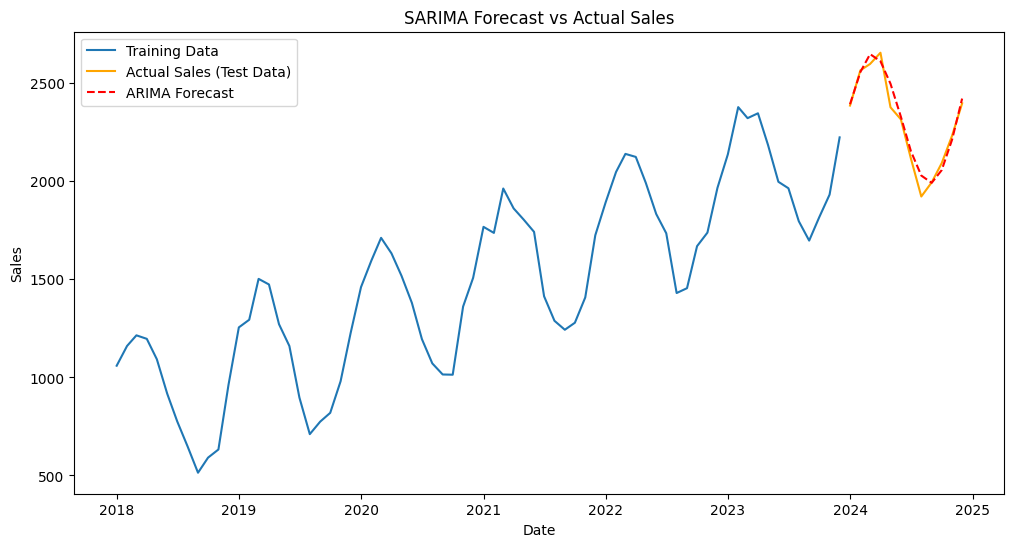

In [ ]:
# Viziális ábrázolás
plt.figure(figsize=(12, 6))
plt.plot(train_df.index, train_df['Sales'], label='Training Data')
plt.plot(test_df.index, test_df['Sales'], label='Actual Sales (Test Data)', color='orange')
plt.plot(predictions_arima.index, predictions_arima, label='ARIMA Forecast', color='red', linestyle='--')
plt.title('SARIMA Forecast vs Actual Sales')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()

## RandomForestRegressor

In [ ]:
# Másolat létrehozása az eredeti adatlhalmazról, hogy ne módosítsuk közvetlenül az eredeti adatokat.
# Így az eredeti df_total érintetlen marad és később is használható a vizualizációhoz

df_lagged = df_total.copy()

# A múltbeli értékesítések időbeli eltolásához (lag), for ciklussal létrehozunk 12 új oszlopot

for i in range(1, 13):
    df_lagged[f'Sales_lag_{i}'] = df_lagged['Sales'].shift(i)

display(df_lagged.head())

,Sales,Sales_lag_1,Sales_lag_2,Sales_lag_3,Sales_lag_4,Sales_lag_5,Sales_lag_6,Sales_lag_7,Sales_lag_8,Sales_lag_9,Sales_lag_10,Sales_lag_11,Sales_lag_12
date,,,,,,,,,,,,,
2018-01-01,1059.59,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-01,1160.29,1059.59,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01,1214.50,1160.29,1059.59,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-04-01,1196.61,1214.50,1160.29,1059.59,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-05-01,1092.65,1196.61,1214.50,1160.29,1059.59,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# Eltávolítjuk azokat a sorokat, ahol NaN értékek keletkeztek a lag miatt
# (az első 12 sorban nem lesz elérhető minden lag érték)

df_lagged.dropna(inplace=True)
display(df_lagged.head())

,Sales,Sales_lag_1,Sales_lag_2,Sales_lag_3,Sales_lag_4,Sales_lag_5,Sales_lag_6,Sales_lag_7,Sales_lag_8,Sales_lag_9,Sales_lag_10,Sales_lag_11,Sales_lag_12
date,,,,,,,,,,,,,
2019-01-01,1254.95,961.10,632.48,591.00,514.10,647.67,775.36,916.93,1092.65,1196.61,1214.50,1160.29,1059.59
2019-02-01,1293.96,1254.95,961.10,632.48,591.00,514.10,647.67,775.36,916.93,1092.65,1196.61,1214.50,1160.29
2019-03-01,1502.36,1293.96,1254.95,961.10,632.48,591.00,514.10,647.67,775.36,916.93,1092.65,1196.61,1214.50
2019-04-01,1473.80,1502.36,1293.96,1254.95,961.10,632.48,591.00,514.10,647.67,775.36,916.93,1092.65,1196.61
2019-05-01,1271.21,1473.80,1502.36,1293.96,1254.95,961.10,632.48,591.00,514.10,647.67,775.36,916.93,1092.65


In [ ]:
# Adatok felosztása train és test halmazokra.
# Az első 60 sor a train adat, a többi a test

train_size = 60
train_df_lagged = df_lagged.iloc[:train_size]
test_df_lagged = df_lagged.iloc[train_size:]

In [ ]:
# Prediktor változók kiválasztása, amikből a modell tanul (lagged értékek) és célváltozó megadása, amit előrejelzünk (Sales)

features = [col for col in train_df_lagged.columns if col != 'Sales' and col != 'date']
target = 'Sales'

In [ ]:
# RandomforestRegressor importálása az sklearn könyvtárból

from sklearn.ensemble import RandomForestRegressor

# RandomForest Regressor objektum létrehozása, fixált véletlenszám geenrátorral  a reprodukálhatóság érdekében
# Így a modell nem fog minden alkalommal más eredményt adni, mert nem fog mindig más véletlen mintából erdőt építeni
# Douglas Adams - Galaxis útikalauz stopposoknak: 42 a válasz az életre, a világmindenségre és mindenre

model = RandomForestRegressor(random_state=42)

# Modell tanítása train adatokon

model.fit(train_df_lagged[features], train_df_lagged[target])

RandomForestRegressor(random_state=42)

In [ ]:
# Előrejelzés készítése a test adatokra a betanított modell segítségével

predictions = model.predict(test_df_lagged[features])

In [ ]:
# Kiértékelési metrikák importálása

from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

mae_rf = mean_absolute_error(test_df_lagged[target], predictions)
rmse_rf = np.sqrt(mean_squared_error(test_df_lagged[target], predictions))

print(f"RandomForestRegressor - Mean Absolute Error: {mae_rf}")
print(f"RandomForestRegressor - Root Mean Squared Error: {rmse_rf}")

RandomForestRegressor - Mean Absolute Error: 116.31153333333299
RandomForestRegressor - Root Mean Squared Error: 151.92765978959017


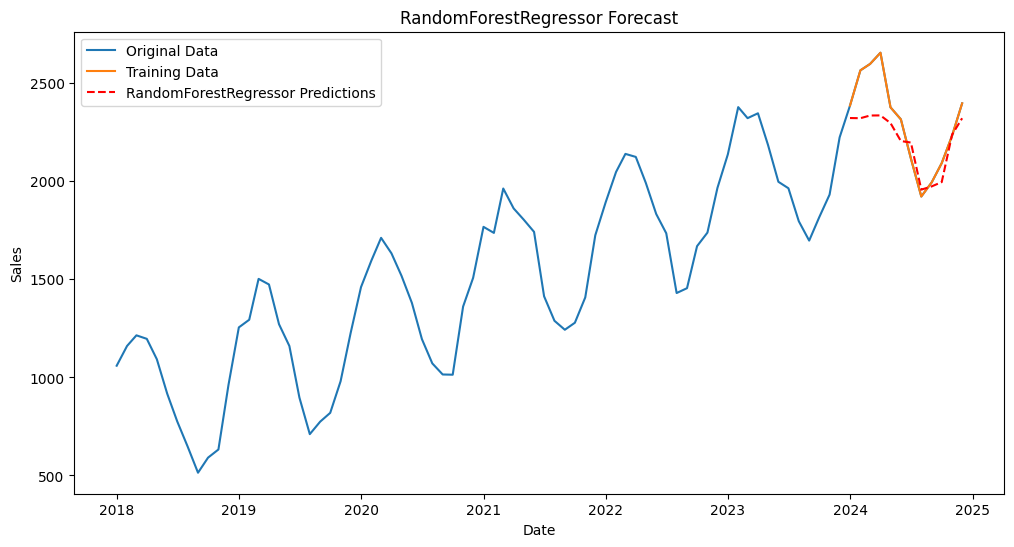

In [ ]:
# Vizualizáció elkészítése

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(df_total.index, df_total['Sales'], label='Original Data')
plt.plot(test_df_lagged.index, test_df_lagged[target], label='Training Data')
plt.plot(test_df_lagged.index, predictions, label='RandomForestRegressor Predictions', color='red', linestyle='--')
plt.title('RandomForestRegressor Forecast')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()

## RandomForestRegressor Hiperparaméterek Optimalizálása

In [ ]:
# GridSearchCV osztály importálása, mely lehetővé teszi a hiperparaméterek szisztematikus keresését

from sklearn.model_selection import GridSearchCV

# Meghatározzuk, a RandomForest modell mely paramétereit szeretnénk optimalizálni

param_grid = {
    'n_estimators': [100, 200, 300],  # Hány döntési fát használjon. 100 az alapértelmezett, 200-200 fa kipróbálásával láthatjuk, hogy nő-e a pontosság, de túl sok fa növeli a futási időt
    'max_depth': [None, 10, 20, 30], # A fák maximális mélysége. A 10,20,30 a mélység korlátozása, hogy meggnézzük, az csökkenti-e a túlillesztést
    'min_samples_split': [2, 5, 10], # Minimális mintaszám egy belső csomópontban. 2 az alapértelmezett, 5 vagy 10 → nagyobb szám = kevesebb osztás, kevesebb túlillesztés, gyorsabb modell
    'min_samples_leaf': [1, 2, 4]   # Minimális mintaszám egy levélcsomópontban. 1 az alapértelmezett, 2 vagy 4 → nagyobb levél = simább, stabilabb becslés, csökkenti a túlillesztést
}

# GridSearchCV objektum létrehozása

grid_search = GridSearchCV(estimator=RandomForestRegressor(random_state=42),
                           param_grid=param_grid, # param_grid: a fent definiált paramétertáblázat
                           cv=3,  # háromszoros keresztvalidáció (három részre osztja az adatot, minden rész egyszer tesztel, kétszer tanít)
                           n_jobs=-1, # az összes CPU magot használja a gyorsabb futtatás érdekében
                           scoring='neg_mean_absolute_error') # A célmetrika a negatív MAE, hiszen minél kisebb a MAE, annál jobb a model


# Tanító adatok kiválasztása:

X_train = train_df_lagged[features] # Bemeneti jellemzők
y_train = train_df_lagged[target] # Célváltozó

# GridSearch elindítása

grid_search.fit(X_train, y_train)

# A legjobb paraméterek és a hozzájuk tartozó MAE érték

print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validation MAE: ", -grid_search.best_score_)

Best parameters found:  {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Best cross-validation MAE:  90.44084499999961


In [ ]:
# Legjobb modell elmentése

best_rf_model = grid_search.best_estimator_

# Test adatok kiválasztása

X_test = test_df_lagged[features]
y_test = test_df_lagged[target]

# Előrejelzés készítése a test adatokra a legjobb modellel

predictions_tuned_rf = best_rf_model.predict(X_test)

# Kiértékelés

mae_tuned_rf = mean_absolute_error(y_test, predictions_tuned_rf)
rmse_tuned_rf = np.sqrt(mean_squared_error(y_test, predictions_tuned_rf))

print(f"Tuned RandomForestRegressor - Mean Absolute Error: {mae_tuned_rf}")
print(f"Tuned RandomForestRegressor - Root Mean Squared Error: {rmse_tuned_rf}")

Tuned RandomForestRegressor - Mean Absolute Error: 115.69359722222241
Tuned RandomForestRegressor - Root Mean Squared Error: 152.80792125089314


## SARIMAX, mint legpontosabb lebontása termék szintre

In [ ]:
# Termékek havi értékesítéshez való hozzájárulásának kiszámítása
# A groupby csoportosít dátum és termék szerint, majd az unstack() függvény segítségével a termékek külön oszlopokba kerülnek
# így egy idő-sorozat jellegű DataFrame-et kapunk, ahol minden sor egy hónap, és minden oszlop egy termék

historical_contribution_all = sales_history.groupby(['date', 'Product'])['Sales'].sum().unstack()

# Minden hónapban kiszámítjuk, hogy az egyes termékek értékesítése mekkora arányt képvisel az összes havi értékesítésbő

historical_ratios_all = historical_contribution_all.divide(historical_contribution_all.sum(axis=1), axis=0)

# Az előző lépésben kapott havi arányokból kiszámítjuk az egyes termékek átlagos arányát az egész időszakra vonatkozóan
# Ez az érték az alapja annak, hogy a SARIMA modell által előrejelzett összesített értékesítést termékekre bontsuk

average_historical_ratios = historical_ratios_all.mean()

# Termék szintű előrejelzések kiszámítása a test időszakra
# A SARIMA modell által előrejelzett összesített értékesítést szétosztjuk az egyes termékek között az átlagos multbeli arányok alapján

product_forecasts_test_avg_ratio = predictions_arima.values[:, None] * average_historical_ratios.values[None, :]


# Eredmény DataFrame-be konvertálása

product_forecasts_test_avg_ratio = pd.DataFrame(product_forecasts_test_avg_ratio, index=predictions_arima.index, columns=average_historical_ratios.index)

In [ ]:
# Teszt időszak valós értékesítési adatainak előkészítése

actual_sales_test = sales_history[sales_history['date'].isin(test_df.index)].pivot(index='date', columns='Product', values='Sales')

# Biztosítjuk, hogy a valós és előrejelzett adatok oszlopai (termékek) ugyanabban a sorrendben legyenek, így az összehasonlítás pontos lesz

actual_sales_test = actual_sales_test[product_forecasts_test_avg_ratio.columns]


# Pontossági metrikák kiszámítása a teszt időszakra

for product in product_forecasts_test_avg_ratio.columns:
    mae = mean_absolute_error(actual_sales_test[product], product_forecasts_test_avg_ratio[product])
    rmse = np.sqrt(mean_squared_error(actual_sales_test[product], product_forecasts_test_avg_ratio[product]))
    print(f"{product}: MAE: {mae:.2f}, RMSE: {rmse:.2f}")

Product_1: MAE: 17.62, RMSE: 24.57
Product_2: MAE: 18.03, RMSE: 20.82
Product_3: MAE: 17.05, RMSE: 19.99
Product_4: MAE: 14.36, RMSE: 16.25
Product_5: MAE: 14.60, RMSE: 18.12
Product_6: MAE: 19.38, RMSE: 22.18
Product_7: MAE: 15.38, RMSE: 19.15
Product_8: MAE: 20.57, RMSE: 25.86


In [ ]:
# SARIMA modell illesztése a teljes adatsorra

model_full_total_sarima = ARIMA(df_total['Sales'], order=(5, 2, 4))
fitted_full_total_sarima = model_full_total_sarima.fit()

# Jövőbeli 12 hónap definiálása

last_date_total = df_total.index.max()
forecast_start_date_total = last_date_total + pd.DateOffset(months=1)
forecast_end_date_total = last_date_total + pd.DateOffset(months=12)

# Összesített jövőbeli értékesítések előrejelzése

future_total_forecast_sarima = fitted_full_total_sarima.predict(start=forecast_start_date_total, end=forecast_end_date_total)

# Termék szintű előrejelzések kiszámítása
# Az összesített jövőbeli előrejelzést szétosztjuk az egyes termékek között az átlagos multbeli arányok alapján

product_forecasts_future = future_total_forecast_sarima.values[:, None] * average_historical_ratios.values[None, :]
product_forecasts_future = pd.DataFrame(product_forecasts_future, index=future_total_forecast_sarima.index, columns=average_historical_ratios.index)


# Termék szintű előrejelzés megjelenítése

display(product_forecasts_future)

Product,Product_1,Product_2,Product_3,Product_4,Product_5,Product_6,Product_7,Product_8
2025-01-01,325.439032,328.001249,332.290142,328.843983,326.292371,327.018776,320.946030,328.798502
2025-02-01,341.496001,344.184636,348.685141,345.068949,342.391443,343.153689,336.781317,345.021225
2025-03-01,348.007497,350.747398,355.333716,351.648573,348.920013,349.696793,343.202915,351.599939
2025-04-01,343.884775,346.592217,351.124203,347.482716,344.786480,345.554058,339.137111,347.434658
2025-05-01,328.887925,331.477296,335.811641,332.328960,329.750307,330.484411,324.347308,332.282998
2025-06-01,309.182137,311.616361,315.691008,312.416997,309.992848,310.682967,304.913577,312.373789
2025-07-01,290.239932,292.525022,296.350034,293.276607,291.000975,291.648813,286.232888,293.236046
2025-08-01,277.625938,279.811717,283.470492,280.530638,278.353906,278.973588,273.793042,280.491839
2025-09-01,275.599770,277.769597,281.401669,278.483270,276.322424,276.937585,271.794847,278.444755
2025-10-01,285.249016,287.494812,291.254050,288.233473,285.996972,286.633670,281.310876,288.193609


# Bottom-Up

## Naive előrejelzés

In [ ]:
# Szükséges könyvtárak betöltése

from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# A termékekhez tartozó előrejelzések és pontossági mutatók tárolásának előkészítése (2 üres szótár létrehozása)

product_forecasts = {}
product_metrics = {}

for product in sales_history['Product'].unique(): # Mindegyik terméket végignézzük
    product_data = sales_history[sales_history['Product'] == product].copy() # Kiválasztjuk az adott termékhez tartozó értékesítési adatokat,
                                                                              # és másolatot készítünk, hogy az eredeti DataFrame megmaradjon

    # A naiv előrejelzés az utolsó ismert érték: ezt mentjük el a product_forecasts szótárba

    last_sales_value = product_data['Sales'].iloc[-1]
    product_forecasts[product] = last_sales_value


    # Ellenőrizzük, hogy van-e legalább két adatpont. Előrejelzési hibát csak ekkor lehet számolni

    if len(product_data) > 1:
        actual_values = product_data['Sales'].iloc[1:].values  # az aktuális értékek a második adattól kezdve
        naive_forecasts = product_data['Sales'].iloc[:-1].values # az előző időpont értékei, mint előrejelzések

        # MAE és RMSE számítása a tényleges és az előrejelzett érték között

        mae = mean_absolute_error(actual_values, naive_forecasts)
        rmse = np.sqrt(mean_squared_error(actual_values, naive_forecasts))

        product_metrics[product] = {'MAE': mae, 'RMSE': rmse} #Elmentjük az adott termékhez tartozó hibamértékeket a product_metrics szótárba
    else:
        product_metrics[product] = {'MAE': np.nan, 'RMSE': np.nan} # Ha csak egy adatpont van, akkor nem lehet hibát számolni, ezért NaN értékeket rendelünk hozzá

# Naive forecast kiírása minter termékhez

for product, forecast in product_forecasts.items():
    print(f"Naive forecast for {product}: {forecast:.2f}")

    # Pontossági mutatók kiírása, ha elérhetőek

    if product in product_metrics:
        print(f"  MAE: {product_metrics[product]['MAE']:.2f}, RMSE: {product_metrics[product]['RMSE']:.2f}")

Naive forecast for Product_1: 289.63
  MAE: 27.14, RMSE: 31.65
Naive forecast for Product_2: 337.94
  MAE: 27.11, RMSE: 33.81
Naive forecast for Product_3: 318.36
  MAE: 25.72, RMSE: 33.70
Naive forecast for Product_4: 297.06
  MAE: 26.53, RMSE: 34.26
Naive forecast for Product_5: 301.35
  MAE: 27.05, RMSE: 32.55
Naive forecast for Product_6: 311.26
  MAE: 26.15, RMSE: 33.53
Naive forecast for Product_7: 283.00
  MAE: 24.80, RMSE: 31.35
Naive forecast for Product_8: 258.53
  MAE: 28.14, RMSE: 35.92


## Exponenciális simítás

In [ ]:
# Exponential Smoothing modell betöltése a statsmodels könyvtárból
# MAE és RMSE számításához szükséges függvények és numpy betöltése

from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# 3 szótár létrehozása:

product_es_forecasts_test = {} # tesztidőszakra vonatkozó előrejelzések
product_es_forecasts_future = {} # jövőbeli (12 hónapos) előrejelzések
product_es_metrics = {} # pontossági mutatók (MAE, RMSE)


for product in sales_history['Product'].unique(): # Végigmegyünk az összes terméken
    product_data = sales_history[sales_history['Product'] == product].copy() # Kiválasztjuk az adott termék adatait, és másolatot készítünk

    # A date oszlopot dátum formátumra konvertáljuk, majd beállítjuk indexnek
    # Sales oszlopot kiválasztjuk, idősort alkotva

    product_data['date'] = pd.to_datetime(product_data['date'])
    product_ts = product_data.set_index('date')['Sales']

    # Az adatok első 80%-át train, a második 20%-át test adathalmazra osztjuk

    train_size = int(len(product_ts) * 0.8)
    train_data, test_data = product_ts[:train_size], product_ts[train_size:]


    try:
        # Létrehozzuk és betanítjuk az exponenciális simítási modellt a train adatokon
        # A modell additív trendet és szezonalitást használ, 12 hónapos periódussal

        model_train = ExponentialSmoothing(train_data, seasonal_periods=12, trend='add', seasonal='add')
        fit_train = model_train.fit()

        # Előrejelzést készítünk a tesztidőszak hosszának megfelelően

        test_forecast = fit_train.forecast(len(test_data))

        # Ha van test adat, akkor az előrejelzés indexét hozzáigazítjuk a test adat indexéhez, és elmentjük az előrejelzést

        if len(test_data) > 0:

            test_forecast.index = test_data.index
            product_es_forecasts_test[product] = test_forecast

            # Kiszámítjuk az MAE és RMSE értékeket a test adat és az előrejelzés között

            mae = mean_absolute_error(test_data, test_forecast)
            rmse = np.sqrt(mean_squared_error(test_data, test_forecast))
            product_es_metrics[product] = {'MAE': mae, 'RMSE': rmse}

            # Kiírjuk az előrejelzés pontosságát

            print(f"{product}: MAE: {mae:.2f}, RMSE: {rmse:.2f}")

            # Ha nincs tesztadat, akkor NaN értékeket rendelünk a metrikákhoz

        else:
            product_es_metrics[product] = {'MAE': np.nan, 'RMSE': np.nan} # Cannot calculate metrics with no test data
            product_es_forecasts_test[product] = pd.Series()


        # A teljes adathalmazon újra betanítjuk a modellt, hogy jövőbeli előrejelzést készítsen

        model_full = ExponentialSmoothing(product_ts, seasonal_periods=12, trend='add', seasonal='add')
        fit_full = model_full.fit()

        # Elkészítjük a következő 12 hónap előrejelzését

        future_forecast = fit_full.forecast(steps=12)
        product_es_forecasts_future[product] = future_forecast

    # Hiba esetén hibaüzenetet írunk ki, és üres értékeket rendelünk a szótárakhoz

    except Exception as e:
        print(f"Could not fit Exponential Smoothing model for {product}: {e}")
        product_es_metrics[product] = {'MAE': np.nan, 'RMSE': np.nan}
        product_es_forecasts_test[product] = pd.Series()
        product_es_forecasts_future[product] = pd.Series()



# Kiírjuk a következő 12 hónapra vonatkozó előrejelzéseket

print("\nExponential Smoothing Forecasts for the next 12 months:")
for product, forecast_values in product_es_forecasts_future.items():
    print(f"\nForecast for {product}:")
    display(forecast_values)

Product_1: MAE: 17.41, RMSE: 23.55
Product_2: MAE: 16.05, RMSE: 18.96
Product_3: MAE: 15.84, RMSE: 19.64
Product_4: MAE: 16.78, RMSE: 19.33
Product_5: MAE: 14.11, RMSE: 19.34
Product_6: MAE: 22.47, RMSE: 25.68
Product_7: MAE: 18.11, RMSE: 22.34
Product_8: MAE: 16.66, RMSE: 21.16

Exponential Smoothing Forecasts for the next 12 months:

Forecast for Product_1:


,0
2025-01-01,329.518701
2025-02-01,337.329504
2025-03-01,338.795324
2025-04-01,356.598910
2025-05-01,335.964968
2025-06-01,320.560617
2025-07-01,296.188387
2025-08-01,279.863753
2025-09-01,269.729239
2025-10-01,276.364295



Forecast for Product_2:


,0
2025-01-01,336.669966
2025-02-01,354.252524
2025-03-01,353.509519
2025-04-01,356.347907
2025-05-01,334.496393
2025-06-01,334.882091
2025-07-01,298.823454
2025-08-01,275.512165
2025-09-01,275.553664
2025-10-01,286.500937



Forecast for Product_3:


,0
2025-01-01,316.697504
2025-02-01,336.259744
2025-03-01,349.605194
2025-04-01,355.924646
2025-05-01,336.491507
2025-06-01,318.807267
2025-07-01,300.578424
2025-08-01,271.487663
2025-09-01,269.003573
2025-10-01,286.926597



Forecast for Product_4:


,0
2025-01-01,336.407697
2025-02-01,346.436134
2025-03-01,371.501986
2025-04-01,354.198894
2025-05-01,346.892993
2025-06-01,323.543190
2025-07-01,312.517392
2025-08-01,269.114484
2025-09-01,288.256095
2025-10-01,280.314614



Forecast for Product_5:


,0
2025-01-01,326.406015
2025-02-01,363.976782
2025-03-01,372.323081
2025-04-01,364.684400
2025-05-01,339.890426
2025-06-01,318.870421
2025-07-01,302.306613
2025-08-01,273.291911
2025-09-01,272.040134
2025-10-01,288.554764



Forecast for Product_6:


,0
2025-01-01,326.010748
2025-02-01,346.483668
2025-03-01,358.428081
2025-04-01,344.539584
2025-05-01,337.415588
2025-06-01,309.975746
2025-07-01,281.594459
2025-08-01,272.541774
2025-09-01,280.961925
2025-10-01,284.527653



Forecast for Product_7:


,0
2025-01-01,344.647090
2025-02-01,346.980938
2025-03-01,357.165983
2025-04-01,358.293033
2025-05-01,326.486630
2025-06-01,311.564974
2025-07-01,300.611939
2025-08-01,294.181820
2025-09-01,276.798600
2025-10-01,283.322825



Forecast for Product_8:


,0
2025-01-01,333.427019
2025-02-01,335.074160
2025-03-01,361.658443
2025-04-01,349.501319
2025-05-01,332.382715
2025-06-01,323.959885
2025-07-01,291.118459
2025-08-01,272.221330
2025-09-01,250.961279
2025-10-01,280.745588


## SARIMA

In [ ]:
# Könyvtárak importálása

from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import warnings

warnings.filterwarnings("ignore")

# Paraméterek definiálása a szezonális és nem szezonális komponensekre

p_values = range(0, 3)
d_values = range(0, 2)
q_values = range(0, 3)
P_values = range(0, 2)
D_values = range(0, 2)
Q_values = range(0, 2)
s = 12 # éves szezonalitás

# Eredmények tárolása
# Minden termékre külön tároljuk a test előrejelzést, a jövőbeli előrejelzést, a metrikákat és a legjobb paramétereket

product_sarima_forecasts_test = {}
product_sarima_forecasts_future = {}
product_sarima_metrics = {}
best_sarima_params = {}

# Végigmegyünk az összes terméken a dataframe-ben
# Kiválasztjuk az adott termék adatait, dátum szerint indexeljük, és felhasználjuk az értékesítési adatokat

for product in sales_history['Product'].unique():
    product_data = sales_history[sales_history['Product'] == product].copy()
    product_data['date'] = pd.to_datetime(product_data['date'])
    product_ts = product_data.set_index('date')['Sales']

    # Adatok felosztása
    # 80%  train, 20% test

    train_size = int(len(product_ts) * 0.8) # 80% for training
    train_data, test_data = product_ts[:train_size], product_ts[train_size:]

    # A legjobb modell kiválasztása az AIC alapján

    best_aic = float("inf")
    best_order = None
    best_seasonal_order = None

    # Grid Search az összes paraméter kombinációra

    for p in p_values:
        for d in d_values:
            for q in q_values:
                for P in P_values:
                    for D in D_values:
                        for Q in Q_values:
                            try:
                                model = ARIMA(train_data, order=(p, d, q), seasonal_order=(P, D, Q, s))
                                fitted = model.fit()
                                if fitted.aic < best_aic:
                                    best_aic = fitted.aic
                                    best_order = (p, d, q)
                                    best_seasonal_order = (P, D, Q, s)
                            except Exception:
                                continue

    best_sarima_params[product] = {'order': best_order, 'seasonal_order': best_seasonal_order}
    print(f"  Best parameters for {product}: Order={best_order}, Seasonal Order={best_seasonal_order}, AIC={best_aic:.2f}")

    # Modell újraillesztése a legjobb paraméterekkel

    if best_order and best_seasonal_order:
        try:
            model_best = ARIMA(train_data, order=best_order, seasonal_order=best_seasonal_order)
            fitted_best = model_best.fit()

            # Előrejelzés készítése a test adatokra

            test_forecast = fitted_best.forecast(steps=len(test_data))
            test_forecast.index = test_data.index

            # Metrikák számítása

            mae = mean_absolute_error(test_data, test_forecast)
            rmse = np.sqrt(mean_squared_error(test_data, test_forecast))
            product_sarima_metrics[product] = {'MAE': mae, 'RMSE': rmse}
            print(f" {product}: MAE={mae:.2f}, RMSE={rmse:.2f}")

            # SARIMA modellből származó előrejelzések elmentése minden termékhez

            product_sarima_forecasts_test[product] = test_forecast

            # Modell újraillesztése az egész idősoron, majd előrejelzés készítése a következő 12 hónapra

            model_full = ARIMA(product_ts, order=best_order, seasonal_order=best_seasonal_order)
            fitted_full = model_full.fit()

            last_date = product_ts.index.max()
            forecast_start_date = last_date + pd.DateOffset(months=1)
            forecast_end_date = last_date + pd.DateOffset(months=12)
            future_forecast = fitted_full.predict(start=forecast_start_date, end=forecast_end_date)
            product_sarima_forecasts_future[product] = future_forecast

        # Ha a modell illesztése vagy előrejelzés hibát dob, akkor NaN értékeket tárol

        except Exception as e:
            print(f"  Could not fit or forecast with best SARIMA model for {product}: {e}")
            product_sarima_metrics[product] = {'MAE': np.nan, 'RMSE': np.nan}
            product_sarima_forecasts_test[product] = pd.Series()
            product_sarima_forecasts_future[product] = pd.Series()
    else:
        print(f"  Could not find optimal SARIMA parameters for {product}.")
        product_sarima_metrics[product] = {'MAE': np.nan, 'RMSE': np.nan}
        product_sarima_forecasts_test[product] = pd.Series()
        product_sarima_forecasts_future[product] = pd.Series()


# Pontossági metrikák megjelenítése minden termékre

print("\nSummary of SARIMA Accuracy Metrics (Test Data):")
for product, metrics in product_sarima_metrics.items():
    print(f"  {product}: MAE={metrics['MAE']:.2f}, RMSE={metrics['RMSE']:.2f}")

# Előrejelzés megjelenítése minden termékre

for product, forecast in product_sarima_forecasts_future.items():
    print(f"\nForecast for {product}:")
    display(forecast)

  Best parameters for Product_1: Order=(0, 1, 1), Seasonal Order=(0, 1, 1, 12), AIC=495.97
 Product_1: MAE=16.97, RMSE=23.16
  Best parameters for Product_2: Order=(0, 1, 1), Seasonal Order=(0, 1, 1, 12), AIC=506.20
 Product_2: MAE=16.05, RMSE=18.96
  Best parameters for Product_3: Order=(0, 1, 1), Seasonal Order=(0, 1, 1, 12), AIC=511.42
 Product_3: MAE=16.03, RMSE=19.76
  Best parameters for Product_4: Order=(0, 1, 1), Seasonal Order=(0, 1, 1, 12), AIC=498.56
 Product_4: MAE=16.20, RMSE=18.22
  Best parameters for Product_5: Order=(0, 1, 1), Seasonal Order=(0, 1, 1, 12), AIC=500.27
 Product_5: MAE=14.93, RMSE=19.97
  Best parameters for Product_6: Order=(0, 1, 1), Seasonal Order=(1, 1, 0, 12), AIC=520.26
 Product_6: MAE=22.71, RMSE=30.02
  Best parameters for Product_7: Order=(0, 1, 1), Seasonal Order=(1, 1, 0, 12), AIC=486.63
 Product_7: MAE=20.43, RMSE=24.66
  Best parameters for Product_8: Order=(0, 1, 1), Seasonal Order=(0, 1, 1, 12), AIC=519.38
 Product_8: MAE=16.73, RMSE=21.20


,predicted_mean
2025-01-01,328.702368
2025-02-01,336.515311
2025-03-01,337.980188
2025-04-01,355.781301
2025-05-01,335.150600
2025-06-01,319.745145
2025-07-01,295.372685
2025-08-01,279.047082
2025-09-01,268.914258
2025-10-01,275.550939



Forecast for Product_2:


,predicted_mean
2025-01-01,336.672272
2025-02-01,354.254559
2025-03-01,353.511318
2025-04-01,356.349509
2025-05-01,334.500416
2025-06-01,334.882824
2025-07-01,298.827798
2025-08-01,275.515658
2025-09-01,275.557424
2025-10-01,286.504588



Forecast for Product_3:


,predicted_mean
2025-01-01,316.699201
2025-02-01,336.261428
2025-03-01,349.606900
2025-04-01,355.925820
2025-05-01,336.494184
2025-06-01,318.809292
2025-07-01,300.580767
2025-08-01,271.491235
2025-09-01,269.006989
2025-10-01,286.927942



Forecast for Product_4:


,predicted_mean
2025-01-01,328.033057
2025-02-01,342.758971
2025-03-01,376.566141
2025-04-01,359.829663
2025-05-01,347.314244
2025-06-01,323.278344
2025-07-01,305.848711
2025-08-01,266.801487
2025-09-01,283.284747
2025-10-01,279.414141



Forecast for Product_5:


,predicted_mean
2025-01-01,327.367476
2025-02-01,364.936007
2025-03-01,373.279346
2025-04-01,365.640607
2025-05-01,340.846984
2025-06-01,319.823358
2025-07-01,303.263752
2025-08-01,274.250091
2025-09-01,272.999819
2025-10-01,289.512968



Forecast for Product_6:


,predicted_mean
2025-01-01,326.698189
2025-02-01,329.381548
2025-03-01,365.853041
2025-04-01,360.587589
2025-05-01,317.302893
2025-06-01,301.520450
2025-07-01,275.004653
2025-08-01,249.450180
2025-09-01,294.420764
2025-10-01,311.219971



Forecast for Product_7:


,predicted_mean
2025-01-01,345.632780
2025-02-01,352.166075
2025-03-01,323.474097
2025-04-01,353.156414
2025-05-01,320.489245
2025-06-01,309.202729
2025-07-01,299.700134
2025-08-01,316.797994
2025-09-01,279.312567
2025-10-01,282.641567



Forecast for Product_8:


,predicted_mean
2025-01-01,333.424868
2025-02-01,335.079890
2025-03-01,361.657885
2025-04-01,349.502899
2025-05-01,332.384273
2025-06-01,323.958773
2025-07-01,291.122981
2025-08-01,272.225883
2025-09-01,250.965911
2025-10-01,280.748071


## RandomForestRegressor

In [ ]:
# Könyvtárak importálása

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [ ]:
# Szótár létrehozása, amelybe minden termék feldolgozott adatai kerülnek

product_features = {}

# Végigmegyünk az összes egyedi terméken

for product in sales_history['Product'].unique():
    product_data = sales_history[sales_history['Product'] == product].copy()
    product_data['date'] = pd.to_datetime(product_data['date'])
    product_data = product_data.sort_values(by='date')

    # Létrehozzuk az előző 12 hónap értékesítési adatait késleltetett változóként

    for i in range(1, 13):
        product_data[f'Sales_lag_{i}'] = product_data['Sales'].shift(i)


    # Eltávolítjuk a hiányzó értékeket, amelyek a késleltetés miatt keletkeztek

    product_data = product_data.dropna()

    # Elmentjük a feldolgozott adatokat a szótárba

    product_features[product] = product_data

In [ ]:
# Üres szótár a train és test adatok tárolására

product_train_test_data = {}

for product, data in product_features.items():
    features = data.drop(columns=['date', 'Product', 'Sales']) # Jellemzők
    target = data['Sales'] # Célváltozó

    # Az adatok 80%-a train, 20%-a test halmazként kerül felhasználásra

    train_size = int(len(data) * 0.8)
    X_train, X_test = features[:train_size], features[train_size:]
    y_train, y_test = target[:train_size], target[train_size:]

    # Elmentjük a train és test adatokat a szótárba

    product_train_test_data[product] = {
        'X_train': X_train,
        'X_test': X_test,
        'y_train': y_train,
        'y_test': y_test
    }


In [ ]:
# Üres szótár a betanított modellek tárolására

product_rf_models = {}

for product, data in product_train_test_data.items():
    X_train = data['X_train']
    y_train = data['y_train']

    # RandomForestRegressor modell létrehozása

    model = RandomForestRegressor(n_estimators=100, random_state=42)

    # Modell tanítása

    model.fit(X_train, y_train)

    # Betanított modell elmentése

    product_rf_models[product] = model

In [ ]:
# Üres szótár az előrejelzések tárolására

product_rf_forecasts = {}

for product, data in product_train_test_data.items():

    # Előrejelzések készítése

    model = product_rf_models[product]
    X_test = data['X_test']
    forecasts = model.predict(X_test)

    # Előrejelzések elmentése

    product_rf_forecasts[product] = forecasts

In [ ]:
# Üres szótár a metrikák tárolására

product_rf_metrics = {}

# Az összes termékre számoljuk a MAE és RMSE értékeket

for product, data in product_train_test_data.items():
    y_test = data['y_test']
    forecasts = product_rf_forecasts[product]
    mae = mean_absolute_error(y_test, forecasts)
    rmse = np.sqrt(mean_squared_error(y_test, forecasts))

    # Metrikák mentése

    product_rf_metrics[product] = {'MAE': mae, 'RMSE': rmse}

# Metrikák megjelenítése

for product, metrics in product_rf_metrics.items():
    print(f"{product}: MAE={metrics['MAE']:.2f}, RMSE={metrics['RMSE']:.2f}")

Product_1: MAE=26.27, RMSE=34.36
Product_2: MAE=27.25, RMSE=33.59
Product_3: MAE=26.84, RMSE=35.14
Product_4: MAE=18.98, RMSE=22.60
Product_5: MAE=25.64, RMSE=31.45
Product_6: MAE=34.50, RMSE=39.74
Product_7: MAE=31.75, RMSE=39.34
Product_8: MAE=18.74, RMSE=30.44


# Termék szintű előrejelzés a MAE minimalizálásával

*   Product_1: Bottom-up SARIMA
*   Product_2: Bottom-up Exponential vagy SARIMA (ugyanaz)
*   Product_3: Bottom-up Exponential
*   Product_4: Top-down SARIMA
*   Product_5: Bottom-up Exponential
*   Product_6: Top-Down SARIMA
*   Product_7: Top-Down SARIMA
*   Product_8: Bottom-up Exponential






In [ ]:
import pandas as pd

# Üres DataFrame létrehozása
# az indexét a product_forecasts_future indexéből vesszük, ami a következő 12 hónap dátumait tartalmazza
# ezzel biztosítjuk az előrejelzések időbeli struktúrájának megfelelőségét

final_product_forecasts = pd.DataFrame(index=product_forecasts_future.index)

# Megfelelő előrejelzések hozzárendelése a termékekhez a MAE minimalizálásával:

# Product_1: Bottom-up SARIMA
final_product_forecasts['Product_1'] = product_sarima_forecasts_future['Product_1']

# Product_2: Bottom-up SARIMA
final_product_forecasts['Product_2'] = product_sarima_forecasts_future['Product_2']

# Product_3: Bottom-up Exponential
final_product_forecasts['Product_3'] = product_es_forecasts_future['Product_3']

# Product_4: Top-down SARIMA
final_product_forecasts['Product_4'] = product_forecasts_future['Product_4']

# Product_5: Bottom-up Exponential
final_product_forecasts['Product_5'] = product_es_forecasts_future['Product_5']

# Product_6: Top-Down SARIMA
final_product_forecasts['Product_6'] = product_forecasts_future['Product_6']

# Product_7: Top-Down SARIMA
final_product_forecasts['Product_7'] = product_forecasts_future['Product_7']

# Product_8: Bottom-up Exponential
final_product_forecasts['Product_8'] = product_es_forecasts_future['Product_8']


# Végső termék szintű előrejelzés megjelenítése

display(final_product_forecasts)

,Product_1,Product_2,Product_3,Product_4,Product_5,Product_6,Product_7,Product_8
2025-01-01,328.702368,336.672272,316.697504,328.843983,326.406015,327.018776,320.946030,333.427019
2025-02-01,336.515311,354.254559,336.259744,345.068949,363.976782,343.153689,336.781317,335.074160
2025-03-01,337.980188,353.511318,349.605194,351.648573,372.323081,349.696793,343.202915,361.658443
2025-04-01,355.781301,356.349509,355.924646,347.482716,364.684400,345.554058,339.137111,349.501319
2025-05-01,335.150600,334.500416,336.491507,332.328960,339.890426,330.484411,324.347308,332.382715
2025-06-01,319.745145,334.882824,318.807267,312.416997,318.870421,310.682967,304.913577,323.959885
2025-07-01,295.372685,298.827798,300.578424,293.276607,302.306613,291.648813,286.232888,291.118459
2025-08-01,279.047082,275.515658,271.487663,280.530638,273.291911,278.973588,273.793042,272.221330
2025-09-01,268.914258,275.557424,269.003573,278.483270,272.040134,276.937585,271.794847,250.961279
2025-10-01,275.550939,286.504588,286.926597,288.233473,288.554764,286.633670,281.310876,280.745588


# Végső előrejelzés vizualizációja

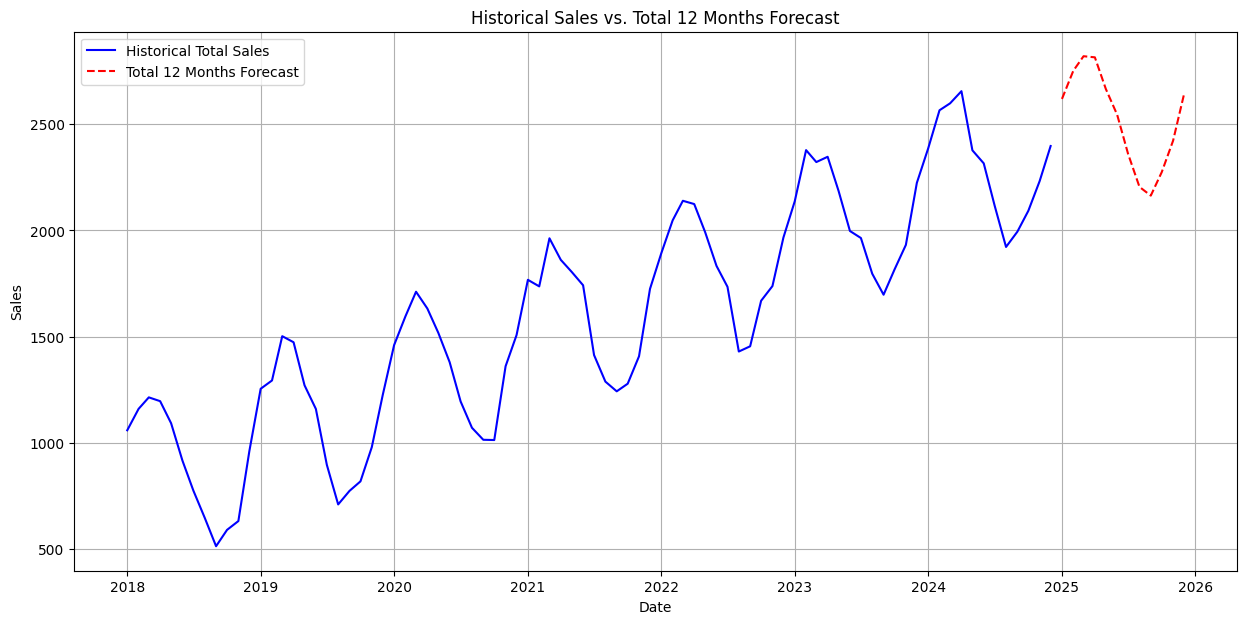

,0
2025-01-01,2618.713968
2025-02-01,2751.084511
2025-03-01,2819.626505
2025-04-01,2814.415061
2025-05-01,2665.576343
2025-06-01,2544.279083
2025-07-01,2359.362287
2025-08-01,2204.860912
2025-09-01,2163.692369
2025-10-01,2274.460494


In [ ]:
import matplotlib.pyplot as plt

# Soronként összeadjuk az összes termék előrejelzését, így kapunk egy teljes előrejelzést a következő 12 hónapra

total_FC = final_product_forecasts.sum(axis=1)

# Vizualizáció

historical_dates = df_total.index
forecast_dates = total_FC.index

plt.figure(figsize=(15, 7))
plt.plot(historical_dates, df_total['Sales'], label='Historical Total Sales', color='blue')
plt.plot(forecast_dates, total_FC, label='Total 12 Months Forecast', color='red', linestyle='--')

plt.title('Historical Sales vs. Total 12 Months Forecast')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.show()

# Teljes előrejelzés megjelenítése a következő 12 hónapra

display(total_FC)
